In [13]:
import time
import os
import torch
import pytorch_mask_rcnn as pmr
    
    
# ------------------ adjustable parameters ---------------------

use_cuda = True # choose to use GPU or not
visualize = True # choose to visualize evaluation results or not
val_num_samples = 5 # number of samples during test
dataset = 'coco' # coco or voc
data_dir = 'E:/PyTorch/data/coco2017' # dataset directory
num_classes = 91 # 91 for coco, 21 for voc
ckpt_path = '../checkpoint_coco.pth' # path where to save the checkpoint.pth

# ------------------ adjustable parameters ---------------------

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('cuda: {}\nuse_cuda: {}\n{} GPU(s) available'.format(torch.cuda.is_available(), use_cuda, torch.cuda.device_count()))
print('\ndevice: {}'.format(device))

valset = pmr.datasets(dataset, data_dir, 'val', True, device=device)
classes = valset.classes
indices = torch.randperm(len(valset)).tolist()
valset = torch.utils.data.Subset(valset, indices[:val_num_samples])

model = pmr.maskrcnn_resnet50(False, num_classes).to(device)

if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    del checkpoint
    torch.cuda.empty_cache()

cuda: True
use_cuda: True
1 GPU(s) available

device: cuda


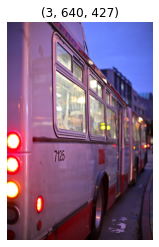

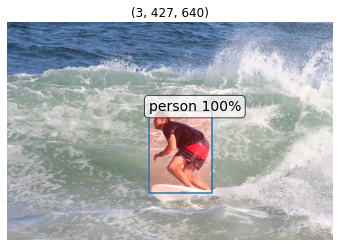

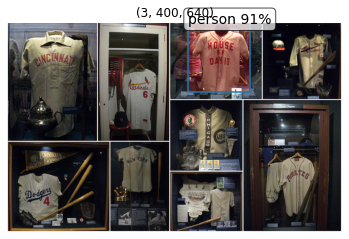

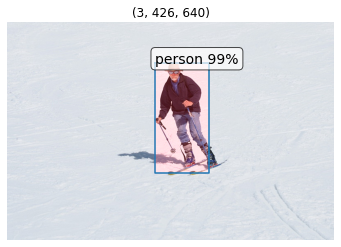

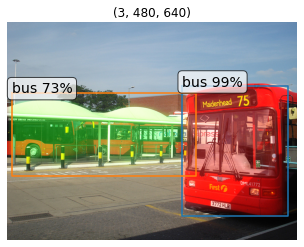

AP on iou 0.50:0.95
1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.1  0.0  0.0
mAP: 1.1

total time: 4.28 s


In [14]:
since = time.time()

# ------------------ test ---------------------

ap_getter = pmr.APGetter(len(classes), device)
model.eval()
for (image, target) in valset:
    with torch.no_grad():
        result = model(image)
        
    ap_getter.collect_data(result, target)

    if visualize:
        #print('  '.join(classes[l.item()] for l in result['labels']))
        #print('  '.join('{:.2f}'.format(p) for p in result['scores']))
        pmr.show(image, result, classes)
        
ap_getter.compute_ap()
print('AP on iou 0.50:0.95')
print('  '.join(str(round(i * 100, 1)) for i in ap_getter.AP_series))
print('mAP: {:.1f}'.format(ap_getter.mAP * 100))

# ------------------ test ---------------------

print('\ntotal time: {:.2f} s'.format(time.time() - since))